2024-10-28 06:41:54.592965: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 06:41:54.603356: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/site-packages/cv2/../../lib64:
2024-10-28 06:41:54.603372: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


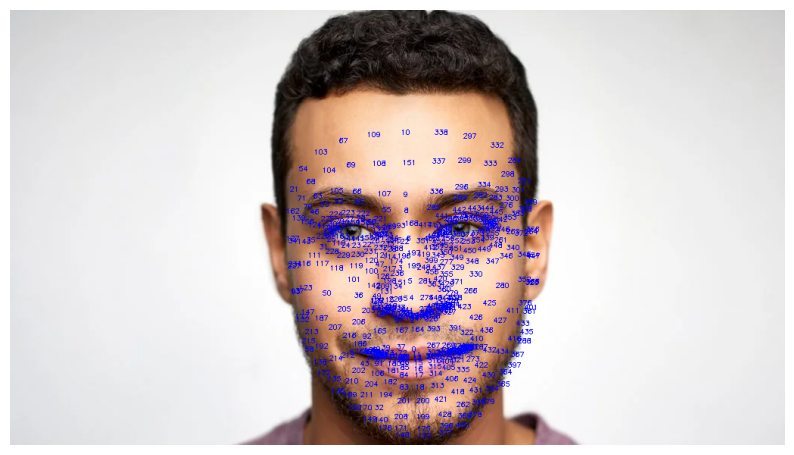

In [1]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt


# 初始化 MediaPipe 人脸关键点检测模型
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

# 读取图像
image = cv2.imread('images/face_4.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 处理图像，检测关键点
results = face_mesh.process(image_rgb)

# 检查是否检测到面部
if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        for idx, landmark in enumerate(face_landmarks.landmark):
            x = int(landmark.x * image.shape[1])
            y = int(landmark.y * image.shape[0])
            # 在图像上标记关键点编号
            cv2.putText(image, str(idx), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)

# 使用 matplotlib 显示图像
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# Face Landmarker 有478个关键点 3D脸部landmarks

检测到的关键点总数: 478


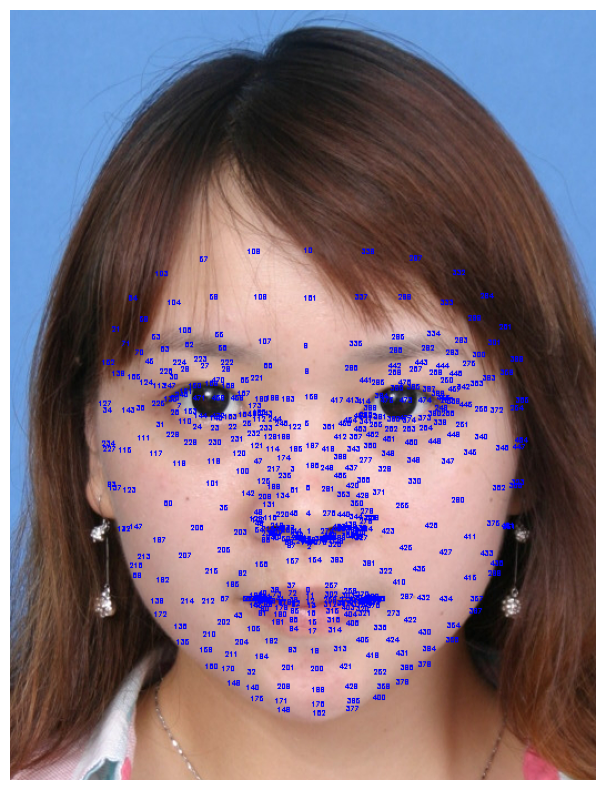

In [4]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# 初始化 MediaPipe Face Landmarker
mp_face_landmarker = mp.solutions.face_mesh  # 替换为最新的 Face Landmarker 模块
face_landmarker = mp_face_landmarker.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

# 读取图像
image = cv2.imread('images/SCUT-FBP-55.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 处理图像，检测关键点
results = face_landmarker.process(image_rgb)

# 存储关键点坐标的列表
landmarks_coords = []

# 检查是否检测到面部
if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        for idx, landmark in enumerate(face_landmarks.landmark):
            x = int(landmark.x * image.shape[1])
            y = int(landmark.y * image.shape[0])
            landmarks_coords.append((idx, x, y))
            # 在图像上标记关键点编号
            cv2.putText(image, str(idx), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (255, 0, 0), 1)

# 输出检测到的关键点总数
total_keypoints = len(landmarks_coords)
print(f"检测到的关键点总数: {total_keypoints}")

# 使用 matplotlib 显示图像
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# 唇形计算

## 计算嘴角上扬和下垂

唇形：宽唇，偏薄，M型唇
嘴角：嘴角平坦，右嘴角倾斜度：165.82°，左嘴角倾斜度：5.28°


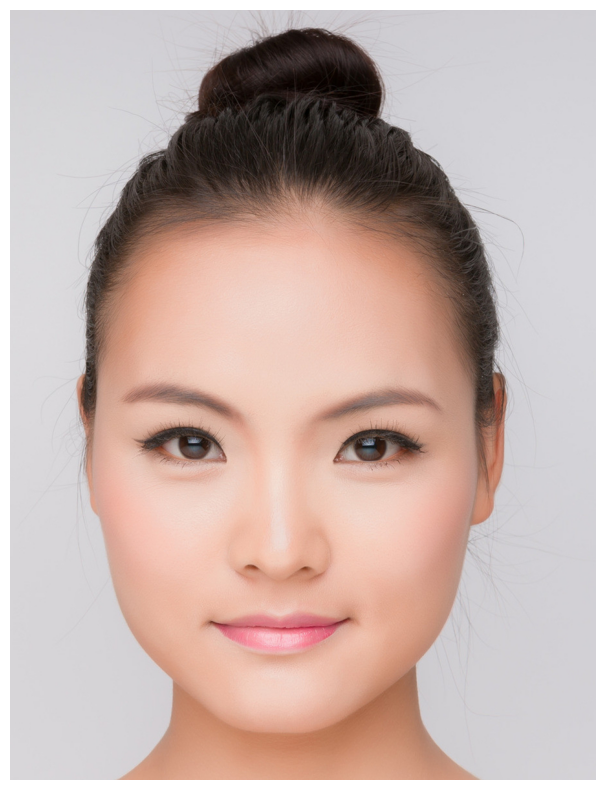

唇形结果: 黄金比例标准唇
分类代码: BAAB


In [3]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

class LipShapeAnalyzer:
    def __init__(self, image_path):
        self.image = cv2.imread(image_path)
        self.image_rgb = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        self.landmarks_coords = {}
        self.result = ''
        self.final_shape = ''
        self.mouth_orientation = ''
        self.right_angle = 0
        self.left_angle = 0

    def detect_landmarks(self):
        mp_face_landmarker = mp.solutions.face_mesh
        face_landmarker = mp_face_landmarker.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)
        
        results = face_landmarker.process(self.image_rgb)
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                for idx, landmark in enumerate(face_landmarks.landmark):
                    x = int(landmark.x * self.image.shape[1])
                    y = int(landmark.y * self.image.shape[0])
                    self.landmarks_coords[idx] = (x, y)

    @staticmethod
    def calculate_angle(p1, p2, p3):
        vec1 = np.array(p1) - np.array(p2)
        vec2 = np.array(p3) - np.array(p2)
        cos_theta = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        return np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))

    def judge_round_wide_lip(self):
        pupil_distance = np.linalg.norm(np.array(self.landmarks_coords[469]) - np.array(self.landmarks_coords[476]))
        lip_width = np.linalg.norm(np.array(self.landmarks_coords[61]) - np.array(self.landmarks_coords[291]))
        if lip_width <= pupil_distance:
            return 'A', '圆唇'  # 圆唇
        else:
            return 'B', '宽唇'  # 宽唇

    def judge_thin_thick_lip(self):
        lip_width = np.linalg.norm(np.array(self.landmarks_coords[61]) - np.array(self.landmarks_coords[291]))
        midpoint_37_267 = (
            (self.landmarks_coords[37][0] + self.landmarks_coords[267][0]) / 2,
            (self.landmarks_coords[37][1] + self.landmarks_coords[267][1]) / 2
        )
        lip_thickness = np.linalg.norm(np.array(midpoint_37_267) - np.array(self.landmarks_coords[17]))
        
        if lip_thickness < lip_width / 2:
            return 'A', '偏薄'  # 偏薄
        else:
            return 'B', '偏厚'  # 偏厚

    def judge_m_lip(self):
        m_lip_angle = self.calculate_angle(
            self.landmarks_coords[37], self.landmarks_coords[0], self.landmarks_coords[267]
        )
        if m_lip_angle >= 20:
            return 'A', 'M型唇'  # M型唇
        else:
            return 'B', '无明显唇峰'  # 无明显唇峰

    def judge_mouth_orientation(self):
        lip_line_points = [
            self.landmarks_coords[80], self.landmarks_coords[81], self.landmarks_coords[82],
            self.landmarks_coords[13], self.landmarks_coords[312], self.landmarks_coords[311], self.landmarks_coords[310]
        ]
        m_lip, b_lip = self.fit_line(lip_line_points)
        m_right, b_right = self.fit_line([self.landmarks_coords[61], self.landmarks_coords[78]])
        m_left, b_left = self.fit_line([self.landmarks_coords[308], self.landmarks_coords[291]])

        self.right_angle = self.calculate_angle(
            self.landmarks_coords[61], self.landmarks_coords[78], self.landmarks_coords[291]
        )
        self.left_angle = self.calculate_angle(
            self.landmarks_coords[308], self.landmarks_coords[291], self.landmarks_coords[61]
        )

        if self.right_angle > 20 and self.left_angle > 20:
            if self.landmarks_coords[61][1] < m_lip * self.landmarks_coords[61][0] + b_lip and \
               self.landmarks_coords[308][1] < m_lip * self.landmarks_coords[308][0] + b_lip:
                return 'B', '嘴角上扬'  # 嘴角上扬
            elif self.landmarks_coords[61][1] > m_lip * self.landmarks_coords[61][0] + b_lip and \
                 self.landmarks_coords[308][1] > m_lip * self.landmarks_coords[308][0] + b_lip:
                return 'A', '嘴角下垂'  # 嘴角下垂
        return 'B', '嘴角平坦'  # 嘴角平坦

    @staticmethod
    def fit_line(points):
        x = [p[0] for p in points]
        y = [p[1] for p in points]
        m, b = np.polyfit(x, y, 1)
        return m, b

    def analyze_lip_shape(self):
        shape1, round_wide_desc = self.judge_round_wide_lip()
        shape2, thin_thick_desc = self.judge_thin_thick_lip()
        shape3, m_lip_desc = self.judge_m_lip()
        shape4, mouth_orientation_desc = self.judge_mouth_orientation()

        self.final_shape = shape1 + shape2 + shape3 + shape4

        # 根据 final_shape 进行结果判断
        if self.final_shape == 'AAAB':
            self.result = '性感M唇'
        elif self.final_shape == 'ABAB':
            self.result = '甜美微笑唇'
        elif self.final_shape == 'BAAB':
            self.result = '黄金比例标准唇'
        elif self.final_shape == 'AABB':
            self.result = '叶形唇'
        elif self.final_shape == 'BABB':
            self.result = '薄唇'
        elif 'A' in self.final_shape[0] or 'A' in self.final_shape[3]:
            self.result = '覆舟唇'
        elif 'B' in self.final_shape[1] and 'B' in self.final_shape[3]:
            self.result = '厚唇'
        else:
            self.result = '未知类型'

        # 输出详细信息
        print(f"唇形：{round_wide_desc}，{thin_thick_desc}，{m_lip_desc}")
        print(f"嘴角：{mouth_orientation_desc}，右嘴角倾斜度：{self.right_angle:.2f}°，左嘴角倾斜度：{self.left_angle:.2f}°")

    def display_result(self):
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        print(f"唇形结果: {self.result}")
        print(f"分类代码: {self.final_shape}")

# 示例使用
analyzer = LipShapeAnalyzer('images/SCUT-FBP-54.jpg')
analyzer.detect_landmarks()
analyzer.analyze_lip_shape()
analyzer.display_result()


# 眉形判断

眉型结果: 平眉
眉眼间距与眼睛距离的比值: 0.59
眉头到鼻尖外侧距离与眼睛间距的比例: 0.82
眉毛宽度与眼球宽度的比例: 0.49


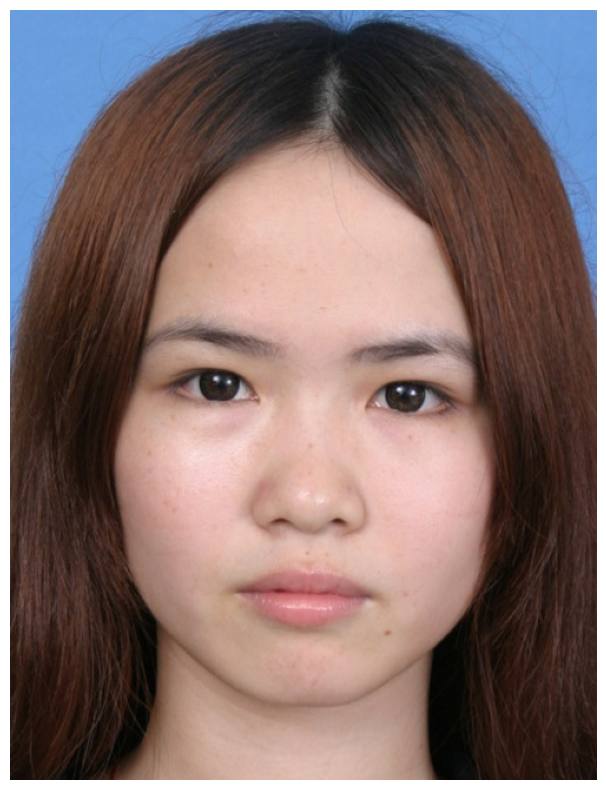

In [11]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

class EyebrowShapeAnalyzer:
    def __init__(self, image_path, landmarks_coords):
        self.image = cv2.imread(image_path)
        self.image_rgb = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        self.landmarks_coords = landmarks_coords
        self.final_shape = ''
        self.brow_eye_ratio = None
        self.brow_to_nose_eye_ratio = None
        self.brow_width_eye_width_ratio = None

    @staticmethod
    def calculate_distance(p1, p2):
        return np.linalg.norm(np.array(p1) - np.array(p2))

    def step1_eyebrow_eye_width_diff(self):
        M = self.calculate_distance(self.landmarks_coords[66], self.landmarks_coords[468])
        N = self.calculate_distance(self.landmarks_coords[296], self.landmarks_coords[473])
        max_brow_eye_distance = max(M, N)
        eye_distance = self.calculate_distance(self.landmarks_coords[133], self.landmarks_coords[362])

        # 计算眉眼间距与眼睛距离的比值
        self.brow_eye_ratio = max_brow_eye_distance / eye_distance if eye_distance != 0 else 0

        if max_brow_eye_distance > eye_distance:
            return 'A'
        else:
            return 'B'

    def step2_eye_spacing_ratio(self):
        midpoint_X = (
            (self.landmarks_coords[107][0] + self.landmarks_coords[55][0]) / 2,
            (self.landmarks_coords[107][1] + self.landmarks_coords[55][1]) / 2
        )
        midpoint_Y = (
            (self.landmarks_coords[336][0] + self.landmarks_coords[285][0]) / 2,
            (self.landmarks_coords[336][1] + self.landmarks_coords[285][1]) / 2
        )
        brow_to_nose_distance = self.calculate_distance(midpoint_X, midpoint_Y)
        eye_distance = self.calculate_distance(self.landmarks_coords[133], self.landmarks_coords[362])

        # 计算眉头到鼻尖外侧距离与眼睛间距的比例
        self.brow_to_nose_eye_ratio = brow_to_nose_distance / eye_distance if eye_distance != 0 else 0

        if brow_to_nose_distance > eye_distance:
            return 'A'
        elif brow_to_nose_distance < eye_distance:
            return 'B'
        else:
            return 'C'

    def step3_eyebrow_length(self):
        temple_162 = self.landmarks_coords[162][0]
        temple_389 = self.landmarks_coords[389][0]
        brow_tail_distance = max(abs(self.landmarks_coords[46][0] - temple_162),
                                 abs(self.landmarks_coords[276][0] - temple_389))
        eye_outer_distance = max(abs(self.landmarks_coords[226][0] - temple_162),
                                 abs(self.landmarks_coords[446][0] - temple_389))

        if brow_tail_distance > eye_outer_distance:
            return 'A'
        else:
            return 'B'

    def step4_eyebrow_thickness(self):
        eye_width1 = (self.calculate_distance(self.landmarks_coords[386], self.landmarks_coords[473]) +
                      self.calculate_distance(self.landmarks_coords[473], self.landmarks_coords[374]))
        eye_width2 = (self.calculate_distance(self.landmarks_coords[159], self.landmarks_coords[468]) +
                      self.calculate_distance(self.landmarks_coords[468], self.landmarks_coords[145]))
        max_eye_width = max(eye_width1, eye_width2)

        brow_width1 = (self.calculate_distance(self.landmarks_coords[105], self.landmarks_coords[52]) +
                       self.calculate_distance(self.landmarks_coords[66], self.landmarks_coords[65])) * 0.5
        brow_width2 = (self.calculate_distance(self.landmarks_coords[334], self.landmarks_coords[282]) +
                       self.calculate_distance(self.landmarks_coords[296], self.landmarks_coords[295])) * 0.5
        max_brow_width = max(brow_width1, brow_width2)

        # 计算眉毛宽度与眼球宽度的比例
        self.brow_width_eye_width_ratio = max_brow_width / max_eye_width if max_eye_width != 0 else 0

        if max_brow_width == max_eye_width / 2:
            return 'A'
        elif max_brow_width > max_eye_width / 2:
            return 'B'
        else:
            return 'C'

    def analyze_eyebrow_shape(self):
        shape1 = self.step1_eyebrow_eye_width_diff()
        shape2 = self.step2_eye_spacing_ratio()
        shape3 = self.step3_eyebrow_length()
        shape4 = self.step4_eyebrow_thickness()

        self.final_shape = shape1 + shape2 + shape3 + shape4

        if self.final_shape in ['AAAA', 'AAAB', 'BCBA', 'AABB', 'BCBB', 'ACBB', 'ACBA']:
            return '基本上不挑眉型'
        elif self.final_shape in ['BAAC', 'BBBC', 'AAAC', 'ACBC', 'BCBC', 'ABAC', 'BABB', 'ABBB']:
            return '平眉'
        elif self.final_shape in ['BCAB', 'ABAB', 'BBAB', 'BCAA', 'BAAB', 'ACAB', 'BAAA']:
            return '直眉'
        elif self.final_shape in ['BBBA', 'BABA', 'BCBA', 'BABC', 'BBBC']:
            return '上挑眉'
        elif self.final_shape in ['AABA', 'ABBA', 'BBAA', 'BBBB']:
            return '柳叶眉'
        elif self.final_shape in ['BCAC', 'AABC', 'ABAA', 'ACAA', 'ABBC', 'ACAC']:
            return '稜角眉'
        else:
            return '未知眉型'

    def display_image(self):
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    def display_ratios(self):
        print(f"眉眼间距与眼睛距离的比值: {self.brow_eye_ratio:.2f}")
        print(f"眉头到鼻尖外侧距离与眼睛间距的比例: {self.brow_to_nose_eye_ratio:.2f}")
        print(f"眉毛宽度与眼球宽度的比例: {self.brow_width_eye_width_ratio:.2f}")


def extract_landmarks(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)
    
    landmarks_coords = {}
    results = face_mesh.process(image_rgb)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for idx, landmark in enumerate(face_landmarks.landmark):
                x = int(landmark.x * image.shape[1])
                y = int(landmark.y * image.shape[0])
                landmarks_coords[idx] = (x, y)
                
    return landmarks_coords

# 导入图像并提取关键点
image_path = 'images/SCUT-FBP-1.jpg'
landmarks_coords = extract_landmarks(image_path)

# 创建眉形分析器并分析眉形
if landmarks_coords:
    analyzer = EyebrowShapeAnalyzer(image_path, landmarks_coords)
    eyebrow_shape = analyzer.analyze_eyebrow_shape()
    print(f"眉型结果: {eyebrow_shape}")
    analyzer.display_ratios()  # 输出比例结果
    analyzer.display_image()  # 显示输入的图像
else:
    print("未检测到人脸或关键点。")


# 眼型判断